# Notebook: Use NN to predict disease from chemicals using Opa2Vec vectors
<b> Author: </b> Ian Coleman <br>
<b> Purpose: </b> Take the vectors created in the opa2vec notebook. This took chemical go functions
    and disease go function, creating vectors for each. Train a NN to predict positive chem-dis relationships from these vectors

In [384]:
## TODO
# Hyperparameter tuning:
# 1. How many uncorrelated pairs do we want
# 2. Epochs
# 3. Batch size
# 4. Number of layers, number of nodes per layer
# 5. Activation functions

In [385]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
import random
from sklearn.model_selection import train_test_split
import sklearn
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pandas_ml import ConfusionMatrix
import json
import subprocess
from correlade import correlade
import distcorr
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
import itertools
import ast
import pdb

#Set random seed
np.random.seed(1606)

### 1. Import Vectors and Pre-Process them

In [386]:
# Import vec file
with open('../../opa2vec/outter.lst', 'r') as file:
    text = file.read()

# Strip and split vector data into list of lists [chem, vec]
text = text.replace('\n', '')
text = text.split(']')
text = [item.strip().split(' [') for item in text]

# Turn it into a data frame
df = pd.DataFrame(text)
df.columns = ['ID', 'Vector']

# Clean
df = df.dropna()
df['Vector'] = df.Vector.map(lambda x: x.rstrip().lstrip().replace('    ', ' ').replace('   ', ' ').replace('  ', ' ').replace(' ', ','))

# Turn vector column into a list
df['Vector'] = df.Vector.map(lambda x: x.split(','))

In [387]:
df.sample(13)

,ID,Vector
1749,C539933-p,"[-1.20175257e-02, 3.78936008e-02, 5.75806163e-..."
735,MESH:D009503,"[-2.10867338e-02, 2.80232518e-03, 4.42544706e-..."
173,MESH:D011009-p,"[-0.01185393, 0.04760887, 0.05772212, -0.10326..."
11647,D011344,"[-2.72519235e-02, 3.86631042e-02, 4.23529930e-..."
1489,C048336-p,"[-1.17891394e-02, 3.15127373e-02, 8.93539861e-..."
590,MESH:D003865-p,"[-4.08085994e-02, 1.88285783e-02, 9.44570526e-..."
6956,D058185-n,"[0.04224442, -0.02706675, 0.20765716, -0.24452..."
6217,D001241-n,"[9.36617255e-02, 1.56397875e-02, 3.03105384e-0..."
5201,C024035-n,"[-0.0190214, 0.01769354, 0.08619656, -0.126308..."
880,MESH:D006105-p,"[-0.02428473, 0.03976286, 0.05556383, -0.09070..."


In [388]:
# # # Create a df template
df2 = pd.DataFrame(columns=['ID','DisDirCorrVec', 'DisInvCorrVec', 'ChemDirCorrVec',
                            'ChemInvCorrVec', 'ChemUnspecCorrVec'])

In [389]:
# Move info over
def is_dis(stringer):
    if ('MESH' in stringer) or ('OMIM' in stringer):
        return True
    else:
        return False

In [390]:
df2['ID'] = df.ID.copy()
df2['ID'] = df2.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))
df2 = df2.drop_duplicates()

In [391]:
# # df2[df2.DisDirCorrVec]
# import pdb

In [392]:
# for index, row in df.iterrows():
#     if is_dis(row.ID):
#         if '-p' in row.ID:
#             pdb.set_trace()
#             df2[df2.ID == row.ID.replace('-p','')].iloc[0]['DisDirCorrVec'] = np.array(row.Vector)
#         else:
#             df2[df2.ID == row.ID.replace('-n', '')].iloc[0].DisInvCorrVec = row.Vector
# #     else:
# #         if '-p' in row.ID:
# #             df2.ChemDirCorrVec = row.Vector
# #         elif '-n' in row.ID:
# #             df2.ChemInvCorrVec = row.Vector
# #         else:
# #             df2.ChemUnspecCorrVec = row.vector

    
# # for index, row in df.iterrows():
# #         subj = '<' + subj_url + row[subj_col] + '> '
# #         if row.pred_code == 'nan':
# #             pred = '<' + 'http://ian.ie/' + row[pred_col] + '> '
# #         else:
# #             pred = '<' + 'http://purl.obolibrary.org/obo/' + row['pred_code'] + '> '
# #         if odd_url[0] in row[obj_col]:
# #             row[obj_col] = row[obj_col].replace(odd_url[0], '')
# #             obj = '<' + odd_url[1] + row[obj_col] + '> '
# #         else:
# #             obj = '<' + obj_url + row[obj_col] + '> '
# #         f.write(subj + pred + obj + '.' + '\n')

In [393]:
# df2.loc[df2.ID =='MESH:D058186'].DisInvCorrVec.iloc[0] = 1

In [394]:
# df2.head()

In [395]:
# def moving_stuff (row):
#     if is_dis(df.DirCorr) and ('-p' in df.DirCorr):
#         df2

In [396]:
# mask = is_dis(df.DirCorr) and ('-p' in df.DirCorr)
# df.loc[mask, 'DirCorr'] = df.Vector

In [397]:
# df.groupby('Vector').sum()

In [398]:
# aggregation_functions = {'price': 'sum', 'amount': 'sum', 'name': 'first'}
# df_new = df.groupby(df['id']).aggregate(aggregation_functions)

In [399]:
# # Remove the -p /-n tags (pos/neg correlation) and add them as columns
# df['DirCorr'] = df.ID.map(lambda x: 1 if '-p' in x else 0)
# df['InvCorr'] = df.ID.map(lambda x: 1 if '-n' in x else 0)
# df['UnspecCorr'] = df.DirCorr + df.InvCorr
# df['UnspecCorr'] = df.UnspecCorr.map(lambda x: 0 if x == 1 else 1)

# df['ID'] = df.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))

In [400]:
# Remove the -p /-n tags (pos/neg correlation) and add them as columns
df['DisDirCorrVec'] = df.ID.map(lambda x: 1 if ('-p' in x and is_dis(x)) else 0)
df['DisInvCorrVec'] = df.ID.map(lambda x: 1 if ('-n' in x) and is_dis(x) else 0)
df['ChemDirCorrVec'] = df.ID.map(lambda x: 1 if ('-p' in x) and not is_dis(x) else 0)
df['ChemInvCorrVec'] = df.ID.map(lambda x: 1 if ('-n' in x) and not is_dis(x) else 0)
df['ChemUnspecVec'] = df.DisDirCorrVec + df.DisInvCorrVec + df.ChemDirCorrVec + df.ChemInvCorrVec
df['ChemUnspecVec'] = df.ChemUnspecVec.map(lambda x: 0 if x > 0 else 1)

df['ID'] = df.ID.apply(lambda x: x.replace('-p', '').replace('-n', ''))

In [401]:
df.ID[1]

'MESH:D018248'

In [402]:
df.sample(7)

,ID,Vector,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecVec
565,MESH:D003929,"[-6.99723605e-03, -2.52499655e-02, 1.61527872e...",1,0,0,0,0
3710,D017313,"[0.01812408, 0.01810183, 0.18475941, -0.234236...",0,0,1,0,0
11155,C519728,"[0.01422205, 0.00985056, 0.14011842, -0.151089...",0,0,0,1,0
8026,C400184,"[0.01079779, -0.00539591, 0.14821383, -0.14191...",0,0,1,0,0
2930,C105671,"[-5.24380477e-03, 4.46078777e-02, 6.08233921e-...",0,0,0,1,0
3355,C014175,"[0.02345133, -0.01966195, 0.12867859, -0.21270...",0,0,0,0,1
3932,C477330,"[0.05452765, -0.01705541, 0.14818624, -0.14000...",0,0,0,1,0


In [403]:
df2.sample(1)

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
11635,C495400,NaN,NaN,NaN,NaN,NaN


In [404]:
map_ddc = dict(zip(df[df.DisDirCorrVec == 1].ID, df[df.DisDirCorrVec == 1].Vector))
map_dic = dict(zip(df[df.DisInvCorrVec == 1].ID, df[df.DisInvCorrVec == 1].Vector))
map_cdc = dict(zip(df[df.ChemDirCorrVec == 1].ID, df[df.ChemDirCorrVec == 1].Vector))
map_cic = dict(zip(df[df.ChemInvCorrVec == 1].ID, df[df.ChemInvCorrVec == 1].Vector))
map_cuc = dict(zip(df[df.ChemUnspecVec == 1].ID, df[df.ChemUnspecVec == 1].Vector))


df2['DisDirCorrVec'] = df2.ID.map(map_ddc)
df2.DisInvCorrVec = df2.ID.map(map_dic)
df2.ChemDirCorrVec = df2.ID.map(map_cdc)
df2.ChemInvCorrVec = df2.ID.map(map_cic)
df2.ChemUnspecCorrVec = df2.ID.map(map_cuc)

In [405]:
df2.sample(13)

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
10989,C015000,NaN,NaN,"[-0.02010187, 0.00542716, 0.05049645, -0.08288...",NaN,NaN
1908,D001379,NaN,NaN,"[0.10578595, 0.01237365, 0.30342, -0.26286152,...","[0.08812901, 0.0320204, 0.33187553, -0.301778,...","[0.0187303, -0.00083258, 0.15660971, -0.159065..."
1715,C101954,NaN,NaN,"[-1.68926194e-02, 3.42476517e-02, 3.97250913e-...","[-0.00383021, 0.03691605, 0.07349062, -0.10609...","[2.27398966e-02, 3.73457768e-03, 1.30814955e-0..."
12443,D014046,NaN,NaN,NaN,NaN,"[-4.78633456e-02, -2.58143968e-03, 4.99010533e..."
5862,D006534,NaN,NaN,"[-0.03754821, 0.03415985, 0.02924754, -0.09692...","[-2.83943824e-02, 2.38502864e-02, 3.33757214e-...","[-2.99657267e-02, 2.15480030e-02, 1.68549120e-..."
10084,C069172,NaN,NaN,"[-0.00758692, 0.01385971, 0.08696242, -0.08362...",NaN,NaN
12186,C048760,NaN,NaN,NaN,"[-1.81677623e-03, 7.91305825e-02, 6.99307546e-...",NaN
8659,C539629,NaN,NaN,"[2.47766916e-03, 4.18871976e-02, 8.82940590e-0...",NaN,NaN
9175,C096128,NaN,NaN,"[-0.02764498, 0.05870311, 0.02797836, -0.08894...",NaN,"[-0.00306818, 0.06337161, 0.05014515, -0.09434..."
1386,MESH:D015458,"[-4.98089679e-02, -2.92280465e-02, 7.80798793e...",NaN,NaN,NaN,NaN


In [406]:
# %reset

In [407]:
# df.DisDirCorrVec.unique()

In [408]:
# df[df.ID == 'MESH:D058186']#.drop_duplicates(subset='ID')

In [409]:
# df.apply(lambda row: row.UnspecCorr)

In [410]:
# # Consolidate all info about an entity onto one line
# mask = (df.DirCorr == 1)
# df.loc[mask, 'DirCorr'] = df.Vector

# mask = (df.InvCorr == 1)
# df.loc[mask, 'InvCorr'] = df.Vector

# mask = (df.UnspecCorr == 1)
# df.loc[mask, 'UnspecCorr'] = df.Vector

### 2. Create DF for NN
Munge the df into the following columns:<br>
ChemID DisID ChemVec DisVec PositiveAssociationExists(binary)

In [411]:
# Step 1: Import file of proven chem-dis positive associations (created in ctd-to-nt notebook from ctd data)
chem_dis = pd.read_csv('../ctd-to-nt/chem-dis-pos-assocs.csv')
chem_dis.head()

,ChemicalID,DiseaseID,DirectEvidence
0,C046983,MESH:D054198,therapeutic
1,C112297,MESH:D006948,marker/mechanism
2,C112297,MESH:D012640,marker/mechanism
3,C039775,MESH:D004827,therapeutic
4,C425777,MESH:D006948,marker/mechanism


In [412]:
chem_dis.DiseaseID.nunique()

3191

In [413]:
chem_dis.shape

(96086, 3)

In [414]:
# Get rid of any chems/diseases that don't have a vector
chem_dis['DiseaseID'] = chem_dis['DiseaseID'].astype(str)
df['ID'] = df['ID'].astype(str)
id_list = df.ID.tolist() # list of chems+diseases with vecs

# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('MESH:', '')
# chem_dis['DiseaseID'] = chem_dis['DiseaseID'].str.replace('OMIM:', '')

chem_dis['hasDVec'] = chem_dis.DiseaseID.map(lambda x: x in id_list)
chem_dis['hasCVec'] = chem_dis.ChemicalID.map(lambda x: x in id_list)
chem_dis = chem_dis.loc[(chem_dis['hasDVec'] == True) & (chem_dis['hasCVec'] == True)]
chem_dis = chem_dis.drop(['hasDVec','hasCVec'], axis=1)

In [415]:
id_list[:4]

['MESH:D058186', 'MESH:D018248', 'MESH:C566304', 'MESH:D000544']

In [416]:
len(id_list)

12747

In [417]:
df2.head()

,ID,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,MESH:D058186,"[3.70542593e-02, 3.52810957e-02, 2.35775501e-0...",NaN,NaN,NaN,"[-0.02229903, 0.01431887, 0.13517049, -0.17734..."
1,MESH:D018248,"[-0.03171459, 0.04182721, 0.11486322, -0.16316...",NaN,NaN,NaN,NaN
2,MESH:C566304,"[-0.0222223, 0.01208713, 0.04465522, -0.074304...",NaN,NaN,NaN,NaN
3,MESH:D000544,"[0.06039888, 0.04937351, 0.2646575, -0.3108586...",NaN,NaN,NaN,"[-0.01752456, 0.01074598, 0.10239156, -0.12939..."
4,MESH:D006528,"[0.11683366, 0.12940668, 0.33550858, -0.443294...",NaN,NaN,NaN,"[-5.14268465e-02, 7.35817128e-04, 6.35062680e-..."


In [418]:
# df2.head()

In [419]:
# merge all info into one df
# this df now contains only correlated diseases and vecs
df_d = df2.copy()
df_d = df_d[['ID', 'DisDirCorrVec', 'DisInvCorrVec']]
# df_d.columns= ['DiseaseID', 'DisDirCorrVec', 'DisInvCorrVec']
# # df_d = ['DiseaseID', 'DVec', 'disDirCorr', 'disInvCorr', 'disUnspecCorr']
df_c = df2.copy()
df_c = df_c[['ID', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']]

df_c = df_c.rename(columns={'ID': 'ChemicalID'})
df_d = df_d.rename(columns={'ID': 'DiseaseID'})
# df_c = ['ChemicalID', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']
df1 = pd.merge(chem_dis, df_d, on='DiseaseID')
df1 = pd.merge(df1, df_c, on='ChemicalID')

# df1['Correlation'] = 1 # currently only have correlated in there

In [420]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,C039775,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",NaN,NaN,NaN,"[-0.00631367, 0.05053534, 0.05186689, -0.07342..."
1,D000086,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
2,D000086,MESH:D000014,marker/mechanism,NaN,NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
3,D000086,MESH:D007249,marker/mechanism,"[0.07972322, -0.00689574, 0.26623446, -0.29851...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
4,D000086,MESH:D020521,therapeutic,"[1.64807625e-02, 1.21755200e-02, 2.55689591e-0...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN


In [421]:
# df1['Correlation'] = df1.DirectEvidence.map(lambda x: 0 if x == 'therapeutic' else 2)

In [422]:
# df1[['DirectEvidence']] = df1[['DirectEvidence']].fillna(value='Uncorrelated')
# df1.DirectEvidence.value_counts()

In [423]:
# df1['target'] = df1.DirectEvidence.astype('category').cat.codes

In [424]:
# df1.head()

In [425]:
# # Consolidate all info about an entity onto one line
# #Chem
# mask = (df1.chemDirCorr == 1)
# df1.loc[mask, 'chemDirCorr'] = df1.CVec

# mask = (df1.chemInvCorr == 1)
# df1.loc[mask, 'chemInvCorr'] = df1.CVec

# mask = (df1.chemUnspecCorr == 1)
# df1.loc[mask, 'chemUnspecCorr'] = df1.CVec

# #Dis ( no unspecified correlation for disease)
# mask = (df1.disDirCorr == 1)
# df1.loc[mask, 'disDirCorr'] = df1.DVec

# mask = (df1.disInvCorr == 1)
# df1.loc[mask, 'disInvCorr'] = df1.DVec

In [426]:
# for col in ['disDirCorr', 'disInvCorr',  'chemDirCorr', 'chemInvCorr', 'chemUnspecCorr']:
#     df1[col] = df1[col].replace(0,np.nan)

In [427]:
# # aggregation_functions = {'disDirCorr': 'first', 'amount': 'sum', 'name': 'first'}
# df2 = df1.groupby(['ChemicalID', 'DiseaseID', 'DirectEvidence']).aggregate('first')

In [428]:
# # df2.columns = df2.columns.get_level_values(0)
# # df2.columns = ['_'.join(tup).rstrip('_') for tup in df2.columns.values]
# df2.columns = ["_".join(x) for x in df2.columns.ravel()]

In [429]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,C039775,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",NaN,NaN,NaN,"[-0.00631367, 0.05053534, 0.05186689, -0.07342..."
1,D000086,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
2,D000086,MESH:D000014,marker/mechanism,NaN,NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
3,D000086,MESH:D007249,marker/mechanism,"[0.07972322, -0.00689574, 0.26623446, -0.29851...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN
4,D000086,MESH:D020521,therapeutic,"[1.64807625e-02, 1.21755200e-02, 2.55689591e-0...",NaN,"[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...",NaN


In [430]:
# # Many of the rows have 1+ empty vec categories, let's fill this with noise
# # TODO run one analysis with the noise ones and one with only the full rows, see the difference
# empty_vec = [0.0] * 200
# df1.DisDirCorrVec.astype(str)[2] == 'nan'


# for col in ['DisDirCorrVec', 'DisInvCorrVec', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']:
#     df1[col] = df1[col].astype(str)
#     df1[col] = df1[col].map(lambda x: empty_vec if x == 'nan' else x)
#     df1[col] = df1[col].astype(list)

In [435]:
df1.ChemUnspecCorrVec.isna().sum()

8033

In [ ]:
#Alternative to filling NaNs with noise, remove all rows with NaNs and see if that helps
# First we'll drop columns with loads of Nas

df1 = df1.dropna

In [323]:
# Create separate dfs of dis-vecs and chem-vecs ( in order to generate additional rows for df1, unrelated pairs)
dis = df.ID.map(lambda x: ('MESH' in x) | ('OMIM' in x))
chems = df.ID.map(lambda x: ('MESH' not in x) & ('OMIM' not in x))

df_chems = df[chems]
df_dis = df[dis]
df_chems = df_chems.reset_index(drop=True)
df_dis = df_dis.reset_index(drop=True)

In [324]:
# df1.loc[3, ['ChemicalID', 'DiseaseID']]

In [325]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec
0,C039775,MESH:D004827,therapeutic,"['0.03703349', '0.01702639', '0.16707323', '-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-0.00631367', '0.05053534', '0.05186689', '-..."
1,D000086,MESH:D004827,therapeutic,"['0.03703349', '0.01702639', '0.16707323', '-0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-0.01689105', '0.0316028', '0.03639323', '-0...","['-0.01365298', '0.05250643', '0.04785401', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,D000086,MESH:D000014,marker/mechanism,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-0.01689105', '0.0316028', '0.03639323', '-0...","['-0.01365298', '0.05250643', '0.04785401', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,D000086,MESH:D007249,marker/mechanism,"['0.07972322', '-0.00689574', '0.26623446', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-0.01689105', '0.0316028', '0.03639323', '-0...","['-0.01365298', '0.05250643', '0.04785401', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,D000086,MESH:D020521,therapeutic,"['1.64807625e-02', '1.21755200e-02', '2.556895...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-0.01689105', '0.0316028', '0.03639323', '-0...","['-0.01365298', '0.05250643', '0.04785401', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [326]:
df_dis.head()

,ID,Vector,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecVec
0,MESH:D058186,"[3.70542593e-02, 3.52810957e-02, 2.35775501e-0...",1,0,0,0,0
1,MESH:D018248,"[-0.03171459, 0.04182721, 0.11486322, -0.16316...",1,0,0,0,0
2,MESH:C566304,"[-0.0222223, 0.01208713, 0.04465522, -0.074304...",1,0,0,0,0
3,MESH:D000544,"[0.06039888, 0.04937351, 0.2646575, -0.3108586...",1,0,0,0,0
4,MESH:D006528,"[0.11683366, 0.12940668, 0.33550858, -0.443294...",1,0,0,0,0


In [327]:
# Add unrelated pairs to df1
no_rows = 30000 #(df1.shape[0]-1)  # This is a parameter to be tuned --> how many uncorrelated pairs do we want
print(df1.shape)
print('to add: ', no_rows)

# Randomly select chems and diseases (as many as there are related pairs)
no_chems = len(df_chems) -1
no_dis = len(df_dis) -1
rand_chems = np.random.choice(no_chems, no_rows, replace=True)
# np.random.seed(1606)
rand_dis = np.random.choice(no_dis, no_rows, replace=True)

# Add the new pairs as rows
for x in range(0, no_rows):
    int1 = rand_chems[x]
    int2 = rand_dis[x]
#     pdb.set_trace()
    chem, cdvec, civec, cuvec = df1.loc[int1, 'ChemicalID'], df1.loc[int1, 'ChemDirCorrVec'], df1.loc[int1, 'ChemInvCorrVec'], df1.loc[int1, 'ChemUnspecCorrVec']
    dis, ddvec, divec = df1.loc[int2, 'DiseaseID'], df1.loc[int2, 'DisDirCorrVec'], df1.loc[int2, 'DisInvCorrVec']
    df1 = df1.append({'ChemicalID':chem, 'DiseaseID':dis, 'DirectEvidence':'unrel',  'DisDirCorrVec': ddvec,
                      'DisInvCorrVec':divec, 'ChemDirCorrVec':cdvec, 'ChemInvCorrVec':civec,"ChemUnspecCorrVec":cuvec, 
                      'Correlation':0}, ignore_index=True)

# ChemicalID	DiseaseID	DirectEvidence	DisDirCorrVec	DisInvCorrVec	ChemDirCorrVec	ChemInvCorrVec	ChemUnspecCorrVec
    
print(df1.shape)
# Drop any duplicates (removes known correlated pairs accidentally generated as uncorrelated)
df1 = df1.drop_duplicates(subset=['ChemicalID', 'DiseaseID'], keep=False)
print(df1.shape)
# Some of the lost duplicates seem to have been there pre this cell...is that an issue? TODO,

(53682, 8)
to add:  30000
(83682, 9)
(54397, 9)


In [328]:
df1[-3:]

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation
83671,D010862,MESH:D010149,unrel,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-2.54189726e-02', '4.01293673e-02', '2.79219...","['-0.03146739', '-0.02375653', '0.0760535', '-...",0.0
83673,C006780,MESH:D013610,unrel,"['-0.00555181', '0.01014307', '0.12428922', '-...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['0.16919897', '-0.00142334', '0.2184323', '-0...","['0.15494879', '-0.02155033', '0.24381956', '-...","['0.17000219', '-0.0130177', '0.23846515', '-0...",0.0
83681,D001971,MESH:D009101,unrel,"['-4.11967486e-02', '-5.14615551e-02', '9.6132...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","['-2.73653194e-02', '4.42639291e-02', '5.67917...","['5.20121725e-03', '1.19470730e-02', '7.732748...","['-0.01100122', '-0.01778104', '0.03620442', '...",0.0


In [329]:
type(df1.DisDirCorrVec[0]) == str

True

In [330]:
# The vectors are currently mostly strings containing strings, turn to list of floats
for col in ['DisDirCorrVec', 'DisInvCorrVec', 'ChemDirCorrVec', 'ChemInvCorrVec', 'ChemUnspecCorrVec']:
    df1[col] = df1[col].map(lambda x: [float(y) for y in eval(x)] if type(x) is str else x)

In [331]:
# tester = df1.DisDirCorrVec.map(lambda x: eval(x) if x is str else x)
# tester = df1.DisDirCorrVec.map(lambda x: [float(y) for y in x])

In [332]:
# tester = df1.DisDirCorrVec.map(lambda x: [float(y) for y in eval(x)] if type(x) is str else x)
# [float(y) for y in eval(tester[1])]

In [333]:
# tester

In [334]:
# Currently the vectors are string objects, convert to lists (whole and then elements)
    
# df1.DisDirCorrVec = df1.DisDirCorrVec.map(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

In [335]:
# Convert the elements of the vectors to actual numbers
# df1['DisDirCorrVec'] = df1.DisDirCorrVec.map(lambda x: [float(i) for i in x])
# df1['DisInvCorrVec'] = df1.DisInvCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemDirCorrVec'] = df1.ChemDirCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemInvCorrVec'] = df1.ChemInvCorrVec.map(lambda x: [float(i) for i in x])
# df1['ChemUnspecCorrVec'] = df1.ChemUnspecCorrVec.map(lambda x: [float(i) for i in x])

In [336]:
df1.DirectEvidence.unique()

array(['therapeutic', 'marker/mechanism', 'unrel'], dtype=object)

In [337]:
# Turn correlation into three options
# [1,0,0] --> neg corr
# [0,1,0] --> no corr
# [0,0,1] --> pos corr
# Note we can't be certain that the unrelated pairs are actually unrelated

df1['y'] = df1.DirectEvidence.map(lambda x: [1,0,0] if x == 'therapeutic' else ([0,1,0] if x == 'unrel' else [0,0,1]))

# Old version:
# df1['y'] = df1.Correlation.map(lambda x: [1,0,0] if x == 0 else ([0,1,0] if x == 1 else [0,0,1]))

In [338]:
# # Chopping out negatively correlated in order to test the new vectors as compared to original setup
# print(df1.shape)
# df1 = df1[df1.Correlation != 0]
# print(df1.shape)
# df1.Correlation = df1.Correlation.map(lambda x: x-1)

In [339]:
# df1.y.value_counts()

### 2. Preprocess
Now that we have the df ready, let's split it into train/test/validation sets and convert it into numpy arrays so it can be consumed by a Keras NN

In [340]:
print(len(df1[df1.DirectEvidence =='marker/mechanism']))
print(len(df1[df1.DirectEvidence =='therapeutic']))
print(len(df1[df1.DirectEvidence == 'unrel']))
# print(len(df1[df1.DirectEvidence.isna()]))

28532
15752
10113


In [341]:
df1.head()

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y
0,C039775,MESH:D004827,therapeutic,"[0.03703349, 0.01702639, 0.16707323, -0.230416...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.00631367, 0.05053534, 0.05186689, -0.07342...",NaN,"[1, 0, 0]"
2,D000086,MESH:D000014,marker/mechanism,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 1]"
4,D000086,MESH:D020521,therapeutic,"[0.0164807625, 0.01217552, 0.255689591, -0.294...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[1, 0, 0]"
10,D000086,MESH:D006965,marker/mechanism,"[0.0463827, -0.00395345, 0.23921703, -0.246568...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 1]"
11,D000086,MESH:D053565,marker/mechanism,"[-0.0352308825, 0.0233300179, 0.0585156679, -0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01689105, 0.0316028, 0.03639323, -0.125525...","[-0.01365298, 0.05250643, 0.04785401, -0.07331...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",NaN,"[0, 0, 1]"


In [342]:
# Merge all vecs into one
df1['all_x'] = df1.DisDirCorrVec + df1.DisInvCorrVec + df1.ChemDirCorrVec + df1.ChemInvCorrVec + df1.ChemUnspecCorrVec

In [343]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df +
df1.all_x = df1.all_x.map(lambda x: np.asarray(x))
df1.y = df1.y.map(lambda x: np.array(x))

In [344]:
# all_X = df1.all_x

In [345]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df
# First create single np array of the two vectors CONCERN: should these be two separate inputs?
# Dvecs = pd.DataFrame(df1.DVec.values.tolist(), index= df1.index)
# Cvecs = pd.DataFrame(df1.CVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = np.array(all_X)

In [346]:
# For Keras, need to turn inputs into numpy arrays instead of pandas df +
# Merge all vecs for a c-d pairing in this order: ddir dinv cdir cinv cunspec
# ddvec = pd.DataFrame(df1.DisDirCorrVec.values.tolist(), index= df1.index)
# divec = pd.DataFrame(df1.DisInvCorrVec.values.tolist(), index= df1.index)
# cdvec = pd.DataFrame(df1.ChemDirCorrVec.values.tolist(), index= df1.index)
# civec = pd.DataFrame(df1.ChemInvCorrVec.values.tolist(), index= df1.index)
# cuvec = pd.DataFrame(df1.ChemUnspecCorrVec.values.tolist(), index= df1.index)
# all_X = Dvecs.merge(Cvecs, how='outer', left_index=True, right_index=True)
# all_X = np.array(all_X)
# all_X = ddvec.merge


In [347]:
# Merge all the above dfs in one line... probably require supercomputer access
# from functools import reduce
# data_frames = [ddvec, divec, cdvec, civec, cuvec]

# df_merged = reduce(lambda  left,right: pd.merge(left,right,
#                                             how='outer'), data_frames)

# df_merged = reduce(lambda  left,right: pd.merge(left_index=True, right_index=True,
#                                             how='outer'), data_frames)

In [348]:
df1.sample(1)

,ChemicalID,DiseaseID,DirectEvidence,DisDirCorrVec,DisInvCorrVec,ChemDirCorrVec,ChemInvCorrVec,ChemUnspecCorrVec,Correlation,y,all_x
18691,D013311,MESH:D007172,marker/mechanism,"[-0.03516325, -0.03760533, 0.0923989, -0.14524...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.01711337, -0.03490911, 0.14840084, -0.1573...","[-0.00862021, -0.00155699, 0.12589115, -0.1585...","[0.01365033, -0.05333043, 0.16401969, -0.18075...",NaN,"[0, 0, 1]","[-0.03516325, -0.03760533, 0.0923989, -0.14524..."


In [349]:
# Now create np array of the y output
# all_y = np.array(df1.y)
# all_y = np.array(df1.y)

In [350]:
# Here I'm going to split y into three columns, model isn't accepting the current col of lists
df1[['neg_corr', 'no_corr', 'pos_corr']] = pd.DataFrame(df1.y.values.tolist(), index= df1.index)
# Turn those three columns into a numpy matrix for y
all_y = df1[['neg_corr', 'no_corr', 'pos_corr']].values

In [382]:
print('y shape: ', all_y.shape)
print('X shape: ', all_X.shape)

y shape:  (54397, 3)
X shape:  (48415,)


In [352]:
df1 = df1.reset_index()


In [354]:
# # Create training, test, val set in a way that we can later look at the rows of each BY ROWS
# total_rows = len(all_X)
# row_numbers = list(range(0, total_rows))

# training_rows = random.sample(row_numbers, int(round(total_rows * .6)))
# row_numbers = set(row_numbers) - set(training_rows)

# test_rows = random.sample(row_numbers, int(round(total_rows * .2)))
# row_numbers = set(row_numbers) - set(test_rows)

# val_rows = list(row_numbers)

In [355]:
# Split into train, test, val BY CHEMICAL instead of by random rows
print('number of chemicals: ', len(df1.ChemicalID.unique()))
print('number of dis: ', len(df1.DiseaseID.unique()))
chems = list(df1.ChemicalID.unique())
random.shuffle(chems)

total_chems = len(chems)
train_chems = chems[:round(total_chems * .6)]
test_chems = chems[round(total_chems * .6):round(total_chems * .8)]
val_chems = chems[round(total_chems * .8):]

print(len(train_chems), len(test_chems), len(val_chems))

# Now get the row numbers for each set of chemicals 

number of chemicals:  3864
number of dis:  929
2318 773 773


In [356]:
df1['train'] = df1.ChemicalID.isin(train_chems)
df1['test'] = df1.ChemicalID.isin(test_chems)
df1['val'] = df1.ChemicalID.isin(val_chems)

In [357]:
# df1.head()

In [358]:
## Commenting out and redoing as the index goes wrong somewhere with this now
# df1 = df1.reset_index()
# training_rows = df1.index[df1.train == True].tolist()
# test_rows = df1.index[df1.test == True].tolist()
# val_rows = df1.index[df1.val == True].tolist()
# Split into train, test, val
# X_train, X_test, X_val = all_X[training_rows], all_X[test_rows], all_X[val_rows]
# y_train, y_test, y_val = all_y[training_rows], all_y[test_rows], all_y[val_rows]

# print(len(training_rows), len(test_rows), len(val_rows))

In [359]:
# X_train

In [360]:
# df1.iloc[15:20]

In [361]:
# Split into train, test, val
X_train, X_test, X_val = df1[df1.train==True].all_x, df1[df1.test==True].all_x, df1[df1.val==True].all_x
y_train, y_test, y_val = df1[df1.train==True].y, df1[df1.test==True].y, df1[df1.val==True].y

print(len(training_rows), len(test_rows), len(val_rows))

29113 9436 9866


In [362]:
# # Split into train, test, val --> OLD WAY
# X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=1606)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1606)

In [363]:
y_train.shape

(32435,)

In [364]:
np.array(X_train).shape

(32435,)

In [365]:
# X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [366]:
#Turn the y_train, X_train etc into multi-dim np arrays
X_train = np.matrix(X_train.tolist())
y_train = np.matrix(y_train.tolist())
X_test = np.matrix(X_test.tolist())
y_test = np.matrix(y_test.tolist())
X_val = np.matrix(X_val.tolist())
y_val = np.matrix(y_val.tolist())

In [367]:
y_train.shape

(32435, 3)

In [368]:
X_train.shape

(32435, 1000)

### 3. Establish NN Model

In [369]:
# 1. Establish the model architecture
#it's safe to say that I don't know what I'm doing here
model = keras.Sequential([
#     keras.layers.Dense(400, activation=tf.nn.relu), 
    keras.layers.Dense(1000, input_dim=1000,  activation=tf.nn.relu), #input_dim=1000,
    keras.layers.Dense(200, activation=tf.nn.relu), #input_dim=1000,
    #     tf.layers.flatten(inputs),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Dense(30, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
    keras.layers.Flatten(), 
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

In [370]:
# ## This is the old model, purely for comparing new vectors to old

# # 1. Establish the model architecture
# #it's safe to say that I don't know what I'm doing here
# model = keras.Sequential([
# #     keras.layers.Dense(400, activation=tf.nn.relu), 
#     keras.layers.Dense(200, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(10, activation=tf.nn.relu),
#     keras.layers.Dropout(rate=0.2, noise_shape=None, seed=None),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
# ])

# # 2. Compile the model (give it loss func, optimise func and eval metric)
# model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
#               loss='binary_crossentropy', # measure of accuracy during training
#               metrics=['accuracy']) # measure for train and testing steps

# # 3. Train
# model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

In [371]:
## Alt model attempt

# data_dim = 400
# timesteps = 1
# num_classes = 3

# model = keras.Sequential()
# model.add(keras.layers.LSTM(30, return_sequences=True,
#                input_shape=(timesteps, data_dim)))  # returns a sequence of vectors of dimension 30
# model.add(keras.layers.LSTM(30, return_sequences=True))  # returns a sequence of vectors of dimension 30
# model.add(keras.layers.LSTM(30))  # return a single vector of dimension 30
# model.add(keras.layers.Dense(3, activation='softmax'))

# model.compile(loss='sparse_categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

# model.summary()
# model.fit(X_train, y_train, batch_size = 400, epochs = 10, verbose = 1)

In [372]:
# 2. Compile the model (give it loss func, optimise func and eval metric)
model.compile(optimizer=tf.train.AdamOptimizer(), # determines how the model is adapted based on loss func
              loss='categorical_crossentropy', # measure of accuracy during training
              metrics=['accuracy']) # measure for train and testing steps 

In [373]:
# Pre-training, set up training params
# earlystop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [377]:
# 3. Train
model.fit(X_train, y_train, epochs=60, validation_data=(X_val, y_val) ) #, callbacks=[earlystop])

Train on 32435 samples, validate on 11065 samples
Epoch 1/60
32435/32435 [==============================] - 4s 113us/step - loss: 0.7082 - acc: 0.6644 - val_loss: 1.3155 - val_acc: 0.5761
Epoch 2/60
32435/32435 [==============================] - 4s 112us/step - loss: 0.6919 - acc: 0.6728 - val_loss: 1.3351 - val_acc: 0.5748
Epoch 3/60
32435/32435 [==============================] - 4s 118us/step - loss: 0.6860 - acc: 0.6777 - val_loss: 1.5772 - val_acc: 0.5275
Epoch 4/60
32435/32435 [==============================] - 3s 101us/step - loss: 0.6796 - acc: 0.6789 - val_loss: 1.4884 - val_acc: 0.5656
Epoch 5/60
32435/32435 [==============================] - 4s 114us/step - loss: 0.6710 - acc: 0.6846 - val_loss: 1.4669 - val_acc: 0.5642
Epoch 6/60
32435/32435 [==============================] - 4s 117us/step - loss: 0.6611 - acc: 0.6901 - val_loss: 1.4914 - val_acc: 0.5796
Epoch 7/60
32435/32435 [==============================] - 4s 112us/step - loss: 0.6610 - acc: 0.6872 - val_loss: 1.6547 - 

32435/32435 [==============================] - 7s 215us/step - loss: 0.5616 - acc: 0.7455 - val_loss: 1.8880 - val_acc: 0.5404
Epoch 60/60
32435/32435 [==============================] - 6s 181us/step - loss: 0.5553 - acc: 0.7489 - val_loss: 2.2273 - val_acc: 0.5485


### ...and evaluate

In [378]:
# 4. Evaluate
# Accuracy
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

10897/10897 [==============================] - 3s 272us/step
Test accuracy: 0.5230797467196224


In [379]:
# Get actual predictions for test set
predictions = model.predict(X_test)
rounded_predictions = [int(float(round(x[0]))) for x in predictions]

In [273]:
# %matplotlib inline
# # Confusion Matrix for binary classificaiton

# confusion_matrix = ConfusionMatrix(y_test, rounded_predictions)
# print("Confusion matrix:\n%s" % confusion_matrix)
# confusion_matrix.plot()

Confusion matrix, without normalization
[[1252  197 1710]
 [ 549   75 1581]
 [ 869  291 4373]]


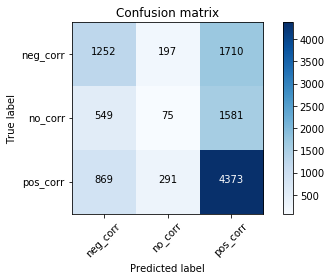

In [380]:
# Plot multiclass confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    

matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plot_confusion_matrix(matrix, ['neg_corr', 'no_corr', 'pos_corr'])

In [381]:
# ROC AUC
print('ROC AUC: ', roc_auc_score(y_test, predictions))

ROC AUC:  0.5878041818727974


### 4. Examine the predictions
Let's look at the predictions the NN gets wrong, see if there's a pattern

In [ ]:
# Create df with the relevant data
test_set = df1.loc[test_rows]
test_set['Predictions'] = predictions
test_set['RoundPredictions'] = rounded_predictions

In [ ]:
# Optimise memory --> set col types for the incoming CSV
cds_cols = ['# ChemicalName', 'ChemicalID', 'DiseaseName', 'DiseaseID', 'DirectEvidence']
cd_col_types = {   
    '# ChemicalName': 'category',
    'ChemicalID': 'category',
    'DiseaseName': 'category',
    'DiseaseID': 'category',
}

In [ ]:
# Let's get the disease and chemical names back! For the sake of eyeballing for patterns
# Read in CTD csv, skipping the intro rows
df_cd = pd.read_csv('../ctd-to-nt/csvs/CTD_chemicals_diseases.csv', usecols=cds_cols, dtype=cd_col_types, skiprows=27)
df_cd = df_cd.drop(0)
df_cd = df_cd.dropna(subset=['DirectEvidence']) # drop if it doesn't have direct evidence

In [ ]:
df_cd.head()

In [ ]:
test_set.head()

In [ ]:
# Get ready for some memory-optimisation
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [ ]:
test_set['Correlation'] = test_set.Correlation.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))
test_set['RoundPredictions'] = test_set.RoundPredictions.astype(np.uint8)
print(mem_usage(test_set['RoundPredictions']))

In [ ]:
# merge in the names

# Because this weirdly requires a tonne of memory, let's optimise (for stupid terrible top-of-range dell laptop)
lst = [chem_dis, df, df_d, df_c, Dvecs, Cvecs]
del lst
test_set = test_set.drop(['DVec', 'CVec', 'index'], axis=1) # these cols are memory intensive
df_cd.ChemicalID = df_cd.ChemicalID.astype('category')
for col in ['DiseaseID', 'ChemicalID', 'DiseaseName', '# ChemicalName', 'DirectEvidence']:
    if str(col) in df_cd.columns: df_cd[col] = df_cd[col].astype('category')
    if col in test_set.columns: test_set[col] = test_set[col].astype('category')
        
test_set = pd.merge(test_set, df_cd[['DiseaseID', 'DiseaseName']], on='DiseaseID')
test_set = pd.merge(test_set, df_cd[['# ChemicalName', 'ChemicalID']], on='ChemicalID')

# weirdly these operations introduce millions of duplicate rows, so delete duplicates:
test_set = test_set.drop_duplicates(list(set(test_set.columns.values))) #- set(['DVec','CVec'])))

In [ ]:
# Import gofunction counts (for each disease and each chem). This csv was output in opa2vec.ipynb
gofunc_counts = pd.read_csv('gofunc_counts.csv')
test_set = pd.merge(test_set, gofunc_counts[['ChemicalID', 'gofunc']], on='ChemicalID')
test_set = test_set.rename(columns = {'gofunc':'ChemGoFuncs'})
test_set = pd.merge(test_set, gofunc_counts[['DiseaseID', 'gofunc']], on='DiseaseID')
test_set = test_set.rename(columns = {'gofunc':'DisGoFuncs'})

# Create combined gofunc count col
test_set['sumGoFuncs'] = test_set.ChemGoFuncs + test_set.DisGoFuncs
test_set['prodGoFuncs'] = test_set.ChemGoFuncs * test_set.DisGoFuncs



In [ ]:
# Create false pos and false neg col
test_set['false_pos'] = abs(test_set.RoundPredictions - test_set.Correlation).map(lambda x: 0 if x > 200 else x)
test_set['true_pos'] = (test_set.RoundPredictions + test_set.Correlation).map(lambda x: 1 if x==2 else 0)

In [ ]:
test_set.sample(13)

In [ ]:
# v=np.linspace(-1,1,10001)
# print (np.corrcoef(v,np.abs(v))[0,1], distcorr.distcorr(v,np.abs(v)))

In [ ]:
# Test data for distance correlation
data = [[4,10],[4,12],[6,13]]
zdf = pd.DataFrame(data,columns=['Name','Age'],dtype=np.int64)
type(zdf.Name[1])

In [ ]:
# correlade.dcorr(zdf)
zdf.head().corr()

In [ ]:
#Distance Correlation
correlade.dcorr(test_set.sample(1300)[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']])

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr()

In [ ]:
#Pearson Correlation
test_set[['Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'sumGoFuncs', 'prodGoFuncs', 'false_pos']].corr(method='spearman')

In [ ]:
test_set[['DiseaseName', '# ChemicalName', 'Correlation', 'Predictions', 'RoundPredictions', 'ChemGoFuncs', 'DisGoFuncs', 'false_pos']].to_csv('predictions.csv', index=False)

In [ ]:
# # This cell is pointless - manually verifying accuracy test
# # Round predictions to int based on threshold, run accuracy-test manually
# predictions = model.predict(X_test)
# threshold = predictions[:].sum()/len(predictions) # Threshold is the mean value of predictions
# predictions = [float(round(x[0]-threshold+0.5)) for x in predictions]
# manual_accuracy = sklearn.metrics.accuracy_score(y_test, predictions, normalize=True, sample_weight=None)
# print(manual_accuracy)

### 5. Calculate Cosine Similary

In [ ]:
# df1.head()

In [ ]:
# Calculate out the cosine similarity and see if there's a difference between groups
def cosine_sim (row):
    return cosine_similarity(np.array(row.DVec).reshape(1, -1), np.array(row.CVec).reshape(1, -1))[0][0]

df1['cosine_sim'] = df1.apply(lambda row: cosine_sim(row), axis=1)

# Compare cosine sim of correlated and uncorrelated groups
print('Cosine mean with no correlation: ', df1[df1.Correlation == 1 ].cosine_sim.mean())
print('Cosine mean with correlation: ', df1[df1.Correlation == 0 ].cosine_sim.mean())

### 6. Save Model

In [ ]:
# # Save model (in two files, one for weights and one for json)
# json_string = model.to_json()
# model.save_weights("model2-0.82.h5")
# with open('model2-0.82.json', 'w') as outfile:
#     json.dump(json_string, outfile)